# Multi-Class Sentiment Recognition for Twitter Tweets using HuggingFace Transformers

#Install Library & Import Library

In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from datasets import Dataset, DatasetDict

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    AutoModel,
    TrainingArguments,
    Trainer,
    pipeline
)

# Install evaluate library
!pip install evaluate
import evaluate

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")

In [ ]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


,0
text,0
label,0
label_name,0


In [ ]:
df['label_name'].value_counts()

,count
label_name,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


## Dataset Analysis

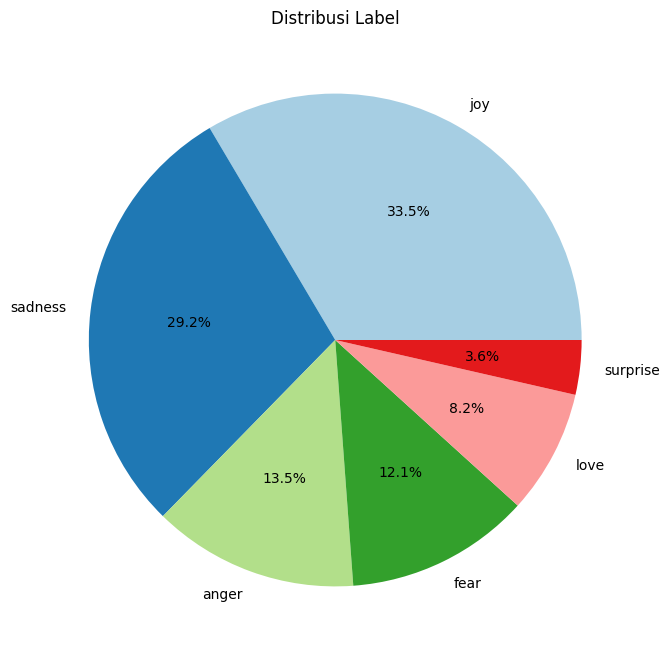

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah kemunculan tiap label
label_counts = df['label_name'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Distribusi Label')

# Tampilkan plot
plt.show()

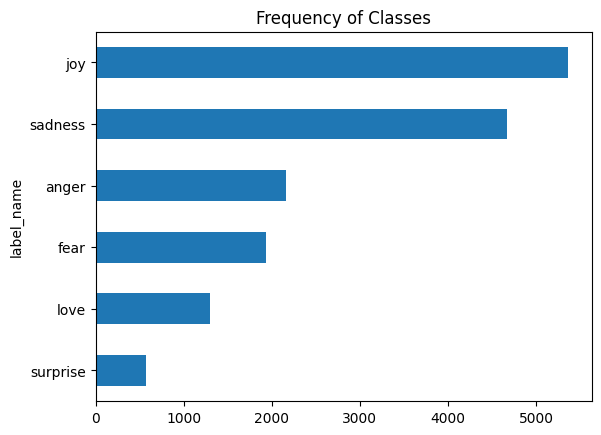

In [ ]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<ipython-input-8-39efa347eb1d>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Label Name")


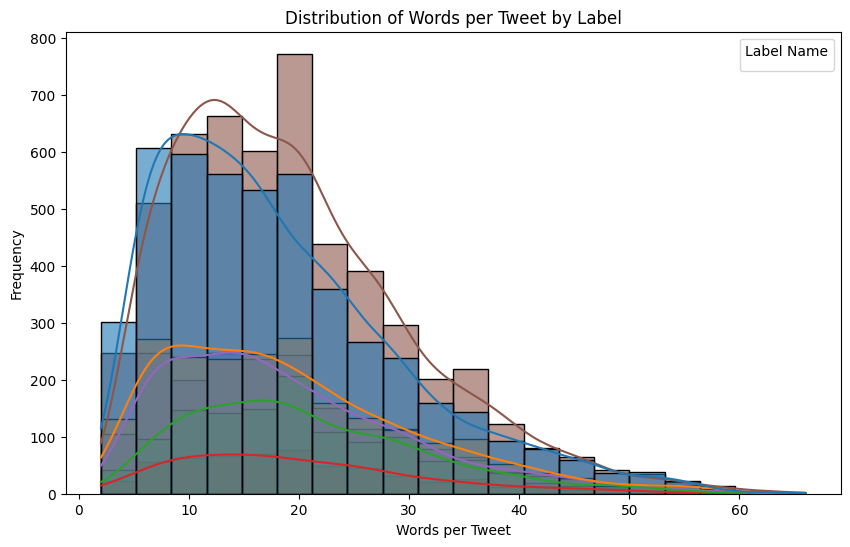

In [ ]:
df['Words per Tweet'] = df['text'].str.split().apply(len)

# Plot histogram untuk setiap kategori dalam label_name
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Words per Tweet", hue="label_name", kde=True, bins=20, alpha=0.6)

plt.xlabel("Words per Tweet")
plt.ylabel("Frequency")
plt.title("Distribution of Words per Tweet by Label")
plt.legend(title="Label Name")
plt.show()


In [ ]:
df.head()

,text,label,label_name,Words per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


## Data Loader and Train Test Split

In [ ]:
# The 'stratify' parameter ensures that the class distribution in the training and test sets
train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [ ]:
dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }

)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Emotion/Sentiment Data

In [ ]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

In [ ]:
dataset['train'][0], dataset['train'][1]

({'text': 'ive had a rather average career because i decided to work less to earn less no rolex anywhere to be seen but have managed to write and even publish some of the short story collections and novels i have in my mind and on my drafts today i will feel successful',
  'label': 1,
  'label_name': 'joy',
  'Words per Tweet': 51},
 {'text': 'when my mother was seriously ill and had to be admitted to the hospital',
  'label': 4,
  'label_name': 'fear',
  'Words per Tweet': 14})

In [ ]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 4921, 2063, 2018, 1037, 2738, 2779, 2476, 2138, 1045, 2787, 2000, 2147, 2625, 2000, 7796, 2625, 2053, 2535, 2595, 5973, 2000, 2022, 2464, 2021, 2031, 3266, 2000, 4339, 1998, 2130, 10172, 2070, 1997, 1996, 2460, 2466, 6407, 1998, 6002, 1045, 2031, 1999, 2026, 2568, 1998, 2006, 2026, 28967, 2651, 1045, 2097, 2514, 3144, 102], [101, 2043, 2026, 2388, 2001, 5667, 5665, 1998, 2018, 2000, 2022, 4914, 2000, 1996, 2902, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [ ]:
# label2id, id2label
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'joy': 1, 'fear': 4, 'sadness': 0, 'anger': 3, 'love': 2, 'surprise': 5},
 {1: 'joy', 4: 'fear', 0: 'sadness', 3: 'anger', 2: 'love', 5: 'surprise'})

## Model Building

In [ ]:
model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model.config.id2label
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Fine-Tuning Transformers

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT model like the one we used in the feature-based approach.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

In [ ]:
num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    run_name="bert_base_experiment",  # Nama eksperimen yang berbeda dari output_dir
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}


## Build Model and Trainer

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded['train'],
                  eval_dataset = emotion_encoded['validation'],
                  tokenizer = tokenizer)

<ipython-input-39-738b75763d1e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.457878,0.857500,0.852001
2,No log,0.301261,0.902500,0.902720


TrainOutput(global_step=350, training_loss=0.6866327776227679, metrics={'train_runtime': 274.0612, 'train_samples_per_second': 81.734, 'train_steps_per_second': 1.277, 'total_flos': 828829590220800.0, 'train_loss': 0.6866327776227679, 'epoch': 2.0})

## Model Evaluation

In [ ]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

  0%|          | 0/50 [00:00<?, ?it/s]

{'test_loss': 0.2910054922103882,
 'test_accuracy': 0.9028125,
 'test_f1': 0.9010784813634883,
 'test_runtime': 78.7905,
 'test_samples_per_second': 40.614,
 'test_steps_per_second': 0.635}

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [ ]:

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       933
           1       0.91      0.92      0.91      1072
           2       0.79      0.74      0.76       261
           3       0.94      0.93      0.93       432
           4       0.86      0.87      0.87       387
           5       0.89      0.61      0.72       115

    accuracy                           0.90      3200
   macro avg       0.89      0.84      0.86      3200
weighted avg       0.90      0.90      0.90      3200



In [ ]:
label2id

{'love': 2, 'joy': 1, 'sadness': 0, 'fear': 4, 'anger': 3, 'surprise': 5}

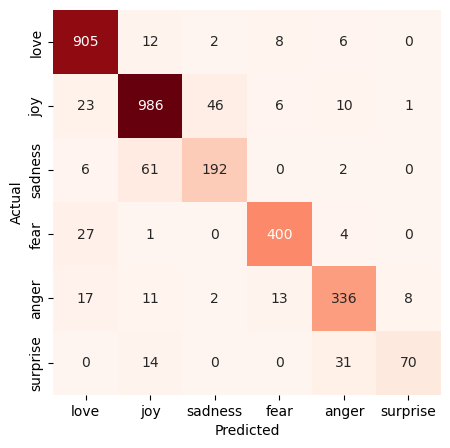

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Build Prediction Function and Store Model

In [ ]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'joy'

In [ ]:
trainer.save_model("bert-base-uncased-sentiment-model")


In [ ]:
classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

[{'label': 'joy', 'score': 0.9631468057632446},
 {'label': 'joy', 'score': 0.7542405128479004},
 {'label': 'love', 'score': 0.6492504477500916},
 {'label': 'sadness', 'score': 0.9719626307487488}]

# Download Model

## Download to Gdrive

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
!zip -r /content/drive/MyDrive/bert-model.zip bert-base-uncased-sentiment-model

## Download local

In [ ]:
import os
import zipfile
from tqdm import tqdm


def zip_dir_with_progress(zip_filename, dir_name):
    # Membuat zip dengan progress bar
    with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:
        # Menggunakan tqdm untuk progress bar
        for root, dirs, files in tqdm(os.walk(dir_name), desc="Zipping files"):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, dir_name)
                zipf.write(file_path, arcname)


# Panggil fungsi untuk zip folder dengan progress
zip_dir_with_progress(
    "/content/bert-base-uncased-sentiment-model.zip",
    "bert-base-uncased-sentiment-model",
)

In [ ]:
from google.colab import files

# Download file zip
files.download("/content/bert-base-uncased-sentiment-model.zip")